# PyTorch & Neural Networks
These exercises will be an introduction to Torch and neural networks. So far you should have at least a general idea of what neural networks are. What I now imagine the main question on your mind is how do I begin programming them? While there are many different Python libraries that can be used for the purpose, most of our work is done using PyTorch. PyTorch is a library which is used for machine learning and creating neural networks. This notebook is an exploration of not only how to build a basic neural network but what parts make up PyTorch. This can be spit into 3 main parts:
- What is a Tensor, and how is it different from a Numpy array and a Pandas dataframe.
- What is a dataloader, and how do we make one.
- What is a neural network, and how do modules allow us to implement them.

The reason we use PyTorch rather than its rival Tensorflow is that currently the academic community seem to prefer it. This means no matter what topic we are studying their is a large chance its code is written in Torch.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Module
import torch.optim as optim
from torch.optim import Optimizer
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
type LossFN = Union[Module]

## Numpy vs Pandas vs Torch
Before we go into the more advanced exercises I wanted to first answer a question that comes up very often. Why are there so many different representations of a list. If you've ever programmed you have probably interacted with a list. A list allows us to store data as well as do vector and matrix operations. In Python this list is dynamically sized, meaning that we can expand it and shrink it with methods like `.append()` and `.remove()`. This permits a degree of flexibility however comes with the drawback that it is slower. This is a problem when we need to do hundreds of operations on lists, which is required within neural networks. So how do we solve this?

### Numpy & Numpy Arrays
Numpy arrays are a solution to this problem of lists being too slow. Numpy arrays are arrays rather than lists meaning they are one fixed sized. This is the first reason they are significantly more efficient. The second reason is that they are implemented in C rather than Python. C being a low-level language makes most of its operations much faster than Python. The last is parallelism, which is the ability of your computer to do multiple calculations at the same time. Numpy arrays are able to do operations on multiple elements within an array at the same time, resulting in an obvious speedup. The below code illustrates this point by running additions on a list of 100,000 numbers.

In [2]:
big_num = 100000

# Python's turn
start_time = time.time()
py_arr = list(range(big_num))
for _ in range(400):
    for i in range(len(py_arr)):
        py_arr[i] += py_arr[i]
print(f"Time for normal Python: {time.time() - start_time}")

# Numpy's turn
start_time = time.time()
np_arr = np.arange(big_num)
for _ in range(400):
        np_arr += np_arr # This is faster than using a seperate loop
print(f"Time for Numpy: {time.time() - start_time}")

Time for normal Python: 2.5891454219818115
Time for Numpy: 0.004225254058837891


An interesting part of the above code is `np_arr += np_arr`. The reason this works is a lot of Numpy operations are considered *vectorised*. This is just a fancy word for meaning most operators such as +, -, /, and more are done element-wise. This means to optimise your code within Python a good approach is to leverage these Numpy operations to speed up array calculations.

Despite this flexibility Numpy arrays do suffer from one main issue, all elements need to be the same type. This means no mixing integers with floats or floats with strings. So what happens if we're reading off of a spreadsheet with multiple forms of data, this is where we need Pandas.

### Pandas & Pandas Dataframes
Pandas dataframes while not used directly in neural networks provide us an easy way to read and manipulate data. Pandas uses their version of a list/matrix called a dataframe. A dataframe is pretty much just a table. It holds columns with names, and data which can include strings, floats, integers, or even complex objects like dates. This makes them key when dealing with most forms of data.

Interestingly despite having multiple different types dataframes aren't as slow as one may think as they are built on top of Numpy arrays. This makes Pandas, while not as fast as numpy, still faster than regular Python.

### Torch Tensors
While Numpy arrays are amazing for general mathematical and scientific calulations they aren't quite as fast as we'd actually like for neural networks, especially when it comes to backpropagation and optimisation. Therefore, PyTorch has their own array implementation called tensors that are optimised for neural networks. These can easily be converted between formats as shown below.

In [3]:
# Converting NDArray -> Tensor
x = np.array([1, 2, 3, 4])
x_tensor = torch.tensor(x)

# Converting List -> Tensor
z = [4, 3, 2, 1]
z_tensor = torch.tensor(z)

# Similar to numpy shape data can be found here as well
print(f"Tensor: {x_tensor}\nWith Shape: {x_tensor.shape}")

Tensor: tensor([1, 2, 3, 4])
With Shape: torch.Size([4])


The killer feature of Tensors that makes them different from Numpy's arrays is the ability to set the device its calculations will be done on. To undestand why this is important we first must discuss the purpose of a GPU.

Every computer uses a central processing unit CPU to calculate values and run code. This device is able to do millions of computations every second making operations such as most of the code in this notebook possible however it suffers from 2 big flaws when it comes to computing neural networks. The first is that the CPU is busy running lots of different things to keep your computer working for you. The next is that it is limited by the amount of processing units it has. This low amount makes it slow at doing vector operations such as those found within neural networks. So rather than using a CPU  we can use a device dedicated to doing very small fast vector operations. In comes the graphics processing unit GPU. Invented in 1999 the GPU was first used to improve how fast graphics on a computer were rendered. This is as the rendering of graphics such as those found within computer games requires many vector projection operations. Rather than having dozens of processing units that are really powerful, a GPU has thousands of really weak processing units. These differences make it much more efficient for us to use a GPU rather than our CPU to train neural networks.

The below code can be used to find what device you can do your calculations on. This can either be your GPU (called CUDA), MPS (for apple computers), or your CPU. This is then followed with an example of putting a tensor onto the device.

In [4]:
# Find device being used
device = (
    "cuda" # For NVIDIA GPUs
    if torch.cuda.is_available()
    else "mps" # For Apple devies
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device.upper()}")

# Place tensor on device
x_tensor.to(device)

Using CPU


tensor([1, 2, 3, 4])

## Dataset & Dataloader
The next part of Tensor flow is the Dataset and Dataloader. From what we have already discussed we know a dataset is a collection of data that can be used to train a ML model. The last question sheet saw us iterating through this data as to find a line of best fit. While this solution works, PyTorch provides a way to do this that is a little nicer. Enter PyTorch's `Dataset` abstract base class. 

A `Dataset` in PyTorch is a class which is can be used to easily iterate through data, it just requires 3 methods to be implemented:
- `__init__`, which initialises the dataset usually by loading the data.
- `__len__`, which gets the total length of the dataset.
- `__getitem__`, which gets a bit of data from the dataset, returning it, usually as a tensor.

To give you an idea of what one looks like below is an example for a basic dataset:

In [5]:
# This a is common toy example within neural networks
# In this dictionary the key (bool, bool) is the data,
# and the item bool is the label. (False, False) has label False, etc.
xor_data = {(False, False): False, (False, True): True, (True, False): True, (True, True): False}

class XORDataset(Dataset):
    def __init__(self, data):
        """Initiliase the XOR problem's dataset"""
        # Note normally you would start by reading a csv file
        # or getting the locations of pictures.
        # Do some modifications to turn it into a tensor
        inputs = [list(k) for k in data.keys()]
        labels = [v for v in data.values()]

        # Save these tensors so that we can use them later
        # variable names don't matter, just make them clear
        self.input = torch.tensor(inputs, dtype=torch.float32)
        self.label = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

    def __len__(self) -> int:
        """Get length of our dataset"""
        # Simply return length of our data
        return len(self.input)

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """Get an item from idx"""
        x = self.input[idx] # get data from inputs
        y = self.label[idx] # get data from label
        return x, y # return them as a tuple so we can unpack

xor_dataset = XORDataset(xor_data)
xor_dataloader = DataLoader(xor_dataset, batch_size=1, shuffle=True)

# Print dataset
for batch_idx, (x, y) in enumerate(xor_dataloader):
    print(f"Batch {batch_idx + 1}\nInputs: {x}\nLabels: {y}")

Batch 1
Inputs: tensor([[1., 0.]])
Labels: tensor([[1.]])
Batch 2
Inputs: tensor([[0., 1.]])
Labels: tensor([[1.]])
Batch 3
Inputs: tensor([[1., 1.]])
Labels: tensor([[0.]])
Batch 4
Inputs: tensor([[0., 0.]])
Labels: tensor([[0.]])


Once you have created a dataset you can now wrap it in PyTorch's `Dataloader`. A dataloader allows you to iterate easily through a dataset while also giving you the ability to change how it gives you data. In the code above we simply wrap the dataset in it and give it a batch_size and set it to shuffle. 
- `batch_size` allows you to load multiple inputs and labels at the same time. This can speed up training time as it allows you to do more calculations at once. Keep this in mind when creating models.
- `shuffle` randomises the order of the dataset, this should be done as it mitigates overfitting.

Once we've done this we are ready to train our model. It should output a tensor representing our input, and its associated label. 

### **(Question 1)** Create a dataset for insurance
Last lesson we created a basic machine learning model from the insurance dataset. This dataset attempts to predict the cost of health-care given a few details. We want to wrap the dataset in PyTorch's dataset. An important part is to make sure that it returns items as tensors. Below is a reminder of some code we used last workshop which may help. This uses numpy so be sure to translate this code into tensors?
```python
data = pd.read_csv('data/insurance.csv')
x = data["age"].to_numpy()
y = data["charges"].to_numpy()
```

**Create a basic dataset for insurance that takes as input a path during initialisation and outputs a tensor representing the age of an individual. This should then be turned into a DataLoader for the dataset**.

In [21]:
class InsuranceDataset(Dataset):
    def __init__(self, path: str):
        """Read the dataset and get the input as a tensor"""
        pass

    def __len__(self) -> int:
        """Get the amount of insurance entries"""
        pass

    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        """Get an item representing the """
        pass
        
path = "data/insurance.csv"
insurance_data = None # Fill in this to create the dataset
insurance_loader = None # Fill in this to turn the dataset to a DataLoader

In [7]:
for batch_idx, (x, y) in enumerate(insurance_loader):
    print(f"Inputs: {x}\nResult: {y}") # Print first results
    break # Don't worry if not exactly the same

Inputs: tensor([[28.0000,  0.0000, 23.8000,  2.0000,  0.0000]])
Result: tensor([3847.6741])


### **(Question 2)** Expand the dataloader
Before we move on lets expand our model further. Currently we are only considering age but with tensors we can consider a list of inputs rather than one. This means that we can easily expand our input to have more features, which will improve our model when we decide to train it.

**Expand your dataloader to include bmi and amount of children**. When you run the above code it should output a tensor with three values as the input.

In [8]:
# Just to remind you of the data we are looking at
pd.read_csv('data/insurance.csv').head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [9]:
d = len(next(iter(insurance_loader))[0][0])
if d % 3 != 0 and d % 5 != 0:
    print("Unsucessfully added bmi and children")

### **(Question 3)** Encoding data in the dataloader
Now that we are considering more inputs our model should improve. Despite this we are missing whether they are a smoker and their gender. If we were to just put them into the tensor we would run into an issue though, the data needs to be a float, which both fields aren't as they are strings (called object by Pandas). To fix this we need to encode the data into a format we can use. This can be done through two main approaches:
- Label encoding, where every category is encoded as an integer. This can be done automatically or done by using a relevant number, such as the amount of appearences. For example a smoker could be classified as `1` while a non-smoker could be classified as `0`
- On hot encoding, where each category is represented as $n$ Boolean columns, where $n$ is the amount of categories. Below is an example with `RainToday`.

| ID | Smoker |
| ---- | ----- |
| 0 | Yes |
| 1 | No |

| ID | Yes | No |
| --- | ---- | ----- |
| 0 | 1 | 0 |
| 1 | 0 | 1 |

**Expand your dataset to have smoker and sex as a part of the tensor by encoding them as floats**.
<details>
  <summary>Hint</summary>
    Some functions which may be useful depending on the approach used are:
    <ul>
        <li><code>pd.get_dummies</code></li>
        <li><code>dataset[...].map({})</code></li>
        <li><code>OneHotEncoder</code> from sklearn</li>
        <li><code>LabelEncoder</code> from sklearn</li>
    </ul>
</details>

In [10]:
d = len(next(iter(insurance_loader))[0][0])
if d % 5 and d % 6 :
    print("Unsucessfully added smoker and sex")

### **(Question 4)** Split the Dataset
Currently the dataset only consists of one main dataset which iterates through all entries. This causes problems however as after we train the model and give it new data it may be predicting what our data says rather than predicting it from the trends. To avoid this we usually split the dataset into 2 halves, the training set and the testing set.
- Training set, consists of most of the data usually 75% and above, and is used to train our ML model.
- Testing set, consists of the rest of the data, and is used to test our dataset at increments to make sure it still accurately predicts cases where it encounters new data.

By splitting the dataset we are able to reduce overfitting and see how our accurate our model is. So before we go about training we first need to go about splitting it. This is done by first calculating the training sizes and test sizes. Before then using `random_split` to split the data. After we have done this we can create new dataloaders for both training and testing data.

**Split the dataset as to create a new training and testing dataloader, where training consists of 80% of the data**. Do it once again in the above code.

## Neural Networks
### XOR Problem
The XOR problem is a toy problem where our goal is to learn XOR. But first what is XOR? Exclusive Or (XOR) in programming is a logic gate found within many computers. In Python we can call it with `^`, for example `0 ^ 1` will be `1` in Python. For the purposes of this task it is just a function (or rule) that we want to be able to find with our neural network. Below is a truth table for XOR, this will be our dataset.

| X | Y | X^Y |
| - | - | --- |
| 0 | 0 |  0  |
| 0 | 1 |  1  |
| 1 | 0 |  1  |
| 1 | 1 |  0  |

If you remember before we actually turned this into a dataset called `XORDataset`. As we have already done this we can move onto the next step, training our model. But first what is a module in PyTorch?

### Modules
PyTorch represents all neural networks with the `Module` abstract base class. This class requires two functions to be implemented.
- `__init__` which stores the layers of the network and its activation functions.
- `forward` which takes the input tensor and does the forward pass by running its layers and associated activation functions as to turn the input tensor into a prediction. Each layer is required to start and end with the same amount of neurons as the last.

Below is an example network for our problem. 

In [11]:
# Define a simple feedforward neural network
class XORNetwork(Module):
    def __init__(self):
        """Use this to store layers and activation functions"""
        super().__init__() # This is required
        # Layers
        self.hidden = nn.Linear(2, 2) # Takes two inputs returns two
        self.output = nn.Linear(2, 1) # Takes two as layer above is the same.
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: Tensor) -> Tensor:
        """Run the forward pass with this data"""
        # Forward pass: input -> hidden layer -> sigmoid -> output layer -> sigmoid
        x = self.sigmoid(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

What makes this interesting is that we can just as easily reuse this module in the future by simply putting it in our network. For example below we expand our network by adding an extra layer. This ability to compose networks in this way allows use to improve architectures made by others. It also means that `Linear`, and `Sigmoid` are also both modules that can be used.

In [12]:
class BigXORNetwork(Module):
    def __init__(self):
        """Use this to store layers and activation functions"""
        super().__init__() # This is required
        self.hidden = nn.Linear(2, 2)
        self.output = XORNetwork()
        # Activation Function
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x: Tensor) -> Tensor:
        """Run the forward pass with this data"""
        # Forward pass: input -> hidden layer -> hidden layer -> sigmoid -> output layer -> sigmoid
        x = self.sigmoid(self.hidden(x))
        x = self.output(x)
        return x

### Training & Testing
Once we have created our model we can start to train it and testing it. Before we start this process there are 3 things that need to be done, first create our model by calling its class, then define a loss function. Think back to linear regression at any given point we first need to calculate how well we are doing at any given step. This starts with our loss function. The last step is defining our optimiser. This is once again similar to linear regression, but rather than creating our own version we can use PyTorch's. Once we have done these three things we can continue.

The training stage follows the steps:
1. Set model to `model.train()`, this ensures any changes to the weights and biases are done.
2. Iterate through batches within the data loader.
3. Assign the iterated values to a device `X, y = X.to(device), y.to(device)`. This is important if we want our model to train fast.
4. Compute the predicted error (*forward pass*). This is done by running the model `model(X)`, before calculating the loss. Think linear regression.
5. Run backpropogation (*back pass*). This is done by calculating the gradients for each neuron. Once we have these gradients we can change the weights and biases by stepping the optimiser. After this we ensure all gradients are set to zero for the next iteration.
6. Optionally print the loss.

Below is an example of this on our XOR problem.

In [13]:
# Create network
model = XORNetwork().to(device)

# Define the loss function and the optimizer
loss_fn = nn.BCELoss()  # Binary Cross Entropy Loss
optimiser = optim.SGD(model.parameters(), lr=0.1)

# Training loop
epochs = 10000
model.train()
for epoch in range(epochs):

    for X, y in xor_dataloader:
        # Forward pass
        y_pred = model(X)
        
        # Compute the loss
        loss = loss_fn(y_pred, y)
        
        # Backward pass and optimization
        loss.backward() # Calculate gradients
        optimiser.step() # Change weights and biases as a result of gradients
        optimiser.zero_grad() # Set gradients to zero
        
    # Print loss every 1000 epochs
    if (epoch+1) % 1000 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Test the model, this is usually done multiple times
model.eval()
with torch.no_grad():  # No need to track gradients for testing
    inputs = torch.tensor([0.0, 0.0])
    test_output = model(inputs)
    print(f"\nGiven input: 0, 0\nResult: {test_output[0]}")

Epoch 1000/10000, Loss: 0.711939811706543
Epoch 2000/10000, Loss: 0.7355634570121765
Epoch 3000/10000, Loss: 1.085893154144287
Epoch 4000/10000, Loss: 0.0374777726829052
Epoch 5000/10000, Loss: 0.022829413414001465
Epoch 6000/10000, Loss: 0.008630456402897835
Epoch 7000/10000, Loss: 0.00952976755797863
Epoch 8000/10000, Loss: 0.007342242635786533
Epoch 9000/10000, Loss: 0.0036172533873468637
Epoch 10000/10000, Loss: 0.0030730527359992266

Given input: 0, 0
Result: 0.003065339755266905


## Convolutional Neural Networks
Now that we have a basic idea of how a neural network works we can expand these concepts to CNNs by letting you do a basic example. 

### Hand-Writing Recognition
Hand-writing recognition is a classic problem neural network that involves recognising numbers from people's hand-writing. For example if we see a drawn 6 we want our model to output a 6. In fact this problem is so common we can save some time by downloading the dataset from Torch. Looking at the call below we see this is fairly similar to calling our own dataset.

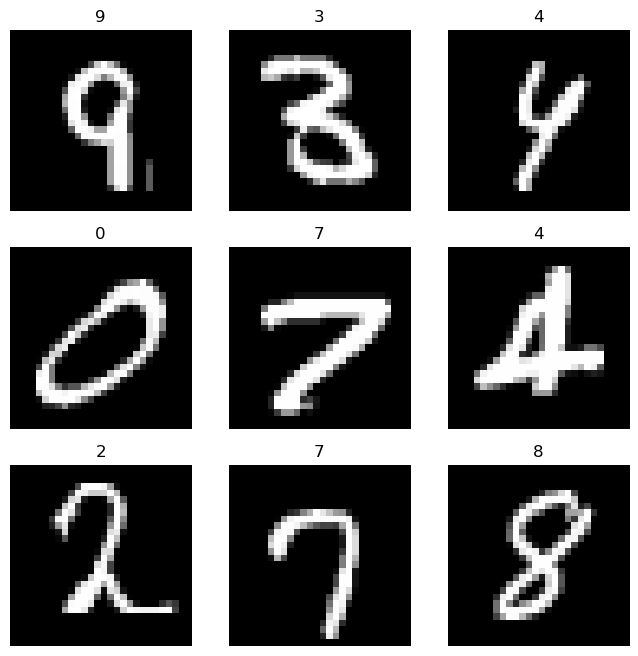

In [14]:
# Remember this place for later
preprocessing = transforms.ToTensor()

# Download training data from torch
training_data = datasets.QMNIST(
    root="data",
    train=True,
    download=True,
    transform=preprocessing,
)

# Download test data from torch
test_data = datasets.QMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Create dataloaders
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Display the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### **(Question 5)** Model
Now that we have seen our data our first goal is to make a basic neural network for our dataset. This involves creating a module like before. An important part to keep in mind is that we can't accept this data in its 2d form. As such our first step is to `flatten` the data. Once this is done we can move onto building out our layers and activation functions.

**Build a basic neural network**. Focus on it working at first, we can improve this later.

In [15]:
class QMNISTNet(Module):
    def __init__(self):
        """Layers for our handwritting model"""
        super().__init__()
        pass

    def forward(self, x: Tensor) -> Tensor:
        """Give handwritting prediction"""
        pass

### **(Question 6)** Training
From our previous example we saw how you would go about training and testing a model. Our first order of business is to make it less messy. A nice way of doing this is by declaring seperate function for `train` and `test`. This will allow us to take parameters such as the dataloader, model, loss function, and optimiser as arguments which can be useful if we want to test multiple different things. Similar to last time you need to iterate through your data, forward pass, and back pass. Look at the previous example if you need some help.

**Create a function that takes in a dataloder, a model, a loss function, an optimiser, and trains the network**. This function will be called every epoch so don't worry about making a loop for the amount of epochs here. 

In [16]:
def train(dataloader: DataLoader, model: Module, loss_fn: LossFN, optimiser: Optimizer):
    """Train the model using the training set"""
    pass

### **(Question 7)** Testing
Once we have finished running training we can now test the model against our testing dataset. This will provide us with a look into its current loss and accuracy. This will be more different to our previous example as we now want to calculate both the loss and accuracy after running the test function. This will be done similar to training however rather than backpropagating we store our loss and accuracy, allowing us to print them at the end of the epoch.

**Create a test function that computes the loss and accuracy for data in the test dataloader**. Make sure to divide the loss and accuracy at the end. To predict our accuracy you can calculate from a prediction `pred`, and a label `y` the result to be:
```python
res = pred.argmax(dim=1, keepdim=True)
acc += res.eq(y.view_as(res)).sum().item()
```

In [17]:
def test(dataloader: DataLoader, model: Module, loss_fn: LossFN):
    """Test the model to see how it compares against the test portion of the dataset"""
    n = len(dataloader.dataset)
    n_batch = len(dataloader)
    loss = 0
    acc = 0
    # Fill this in, what do we want to do next? Perhaps iterate through data
    # to calculate accuracy?
    loss /= n_batch
    acc /= n
    print(f"Accuracy: {(acc):>0.1f}%, Avg loss: {loss:>8f}")

### **(Question 8)** Loss & Optimiser
The final step before we can run our model is choosing a loss function and optimiser. For now you can just enter the previously used ones, however be sure to change these later to see how the accuracy changes given these variables.

**Choose a loss function and optimiser**.

In [18]:
model = QMNISTNet()
loss_fn = None # Fill this in
optimiser = None # Fill this in

### Results
Given that you have done the previous steps correctly you should be able to run the below code as to train the model for yourself. This code runs 10 epochs before finishing. If you are willing to spend more time training be sure to modify the amount of epochs. Don't expect this to be super accurate on the first try as we are still learning.

In [19]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}/{epochs}: ", end="")
    train(train_dataloader, model, loss_fn, optimiser)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1/10: Accuracy: 0.4%, Avg loss: 2.260161
Epoch 2/10: Accuracy: 0.5%, Avg loss: 2.204112
Epoch 3/10: Accuracy: 0.6%, Avg loss: 2.111032
Epoch 4/10: Accuracy: 0.6%, Avg loss: 1.950027
Epoch 5/10: Accuracy: 0.7%, Avg loss: 1.697428
Epoch 6/10: Accuracy: 0.7%, Avg loss: 1.384210
Epoch 7/10: Accuracy: 0.8%, Avg loss: 1.106342
Epoch 8/10: Accuracy: 0.8%, Avg loss: 0.912434
Epoch 9/10: Accuracy: 0.8%, Avg loss: 0.783257
Epoch 10/10: Accuracy: 0.8%, Avg loss: 0.693901
Done!


### **(Question 9)** Preprocessing
Now that you have done all the previous steps you should have a model that ranges from ok to pretty decent. However, one thing that may be holding you back is the lack of preprocessing. So what is preprocessing and how can we use it?

Preprocessing is the idea of modifying your data before you use it in a network. An example you have already done is back when you encoded male and female as 0 and 1. Another example can also be filling in data points that you can't find with a mean/median. With images this approach is different, rather we want to normalise the data, do rotations, change pixels and more.

The goal with preprocessing in general is to make our dataset more generalisable so that it not only can have an easier time training, but be able to be ran on new data and get a more accurate result. Below is an example of how we can change the preprocessing steps in our code. This creates a pipeline that starts by rotating before turning our input to a tensor.
```python
preprocessing = transforms.Compose([
    transforms.RandomRotation((0, 360)),
    transforms.ToTensor(),
])
```

**Modify the preprocessing step to be more advanced**. This step can be found in the place you downloaded the dataset. Be sure to experiment with different things not just rotations.

### **(Question 10)** Improve your Model
Congratulations you have trained a neural network. Most likely the results from this will be less than satisfactory, with it being possibly lower than 50%. Now this is only the start of your journey, every single variable whether your *loss function*, *optimiser (and its learning rate)*, *extracted features*, *model layers*, and more can be changed as to create a better model. This process if called **hyperparameter tuning** and is a large part of machine learning. If you ever want to get better at ML you must be willing to spend the time the improve your model. Therefore the last task is:

**Improve your model to have a better accuracy**. Tune respective parameters as to produce the best result possible. This will require some research.

In [20]:
# If you want to pretify your loss and accuracy graphs here:
def plot_loss_acc(loss: List[int], acc: List[int]):
    """Helper to plot loss and accuracy if you store them in a list"""
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(16,5))
    ax0.plot(acc, 's-')
    ax0.set_title(f'Final test accuracy {acc[-1]:.2f}%')
    ax0.set_ylabel('Accuracy%')
    ax0.set_xlabel('Epochs')
    ax1.plot(loss, 's-')
    ax1.set_title(f'Final test loss {loss[-1]:.2f}')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')